In [52]:
#First I will copy some thing we need from the ROBERTA notebook
import keras_nlp
import tensorflow
import keras_tuner
import keras
import pandas as pd
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model, Model
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem

In [2]:
#Roberta fixed parameters

#Fixed parameters
PROCESSING_FIXED = {'start_char': "<s>",
                    'end_char': "</s>", 
                    'pad_char': "<pad>",
                    'mas_char': "<mask>"}

INDICES_TOKEN = {0: 'c',
                 1: 'C',
                 2: '(',
                 3: ')',
                 4: 'O',
                 5: '1',
                 6: '2',
                 7: '=',
                 8: 'N',
                 9: '@',
                 10: '[',
                 11: ']',
                 12: 'n',
                 13: '3',
                 14: 'H',
                 15: 'F',
                 16: '4',
                 17: '-',
                 18: 'S',
                 19: 'Cl',
                 20: '/',
                 21: 's',
                 22: 'o',
                 23: '5',
                 24: '+',
                 25: '#',
                 26: '\\',
                 27: 'Br',
                 28: 'P',
                 29: '6',
                 30: 'I',
                 31: '7',
                 32: PROCESSING_FIXED['start_char'],
                 33: PROCESSING_FIXED['end_char'],
                 34: PROCESSING_FIXED['pad_char'],
                 35: PROCESSING_FIXED['mas_char']}                
TOKEN_INDICES = {v: k for k, v in INDICES_TOKEN.items()}



In [4]:
df = pd.read_csv('../../Databases/purchasable.smi', sep='\t', header=None)

In [5]:
df

In [6]:
#Treat the data in a similar way as in the fine-tuning notebook
#dropna of activity_class
df = df.dropna()
#Also, remove any smiles string that contains a character NOT in our vocabulary (excluding pad, start and end chars). Hint: allowed_chars = [t for t in TOKEN_INDICES.keys()][:-3]
allowed_chars = [t for t in TOKEN_INDICES.keys()][:-3]
df = df[df[0].apply(lambda x: all(char in allowed_chars for char in x))]
#drop data longer than 90 characters
df = df[df[0].apply(lambda x: len(x)<=90)]


In [ ]:
#Eliminate all molecules that do not comply with the lipinski rule of 5 see https://dev.drugbank.com/guides/terms/lipinski-s-rule-of-five
from rdkit import Chem
from rdkit.Chem import Lipinski
from rdkit.Chem import Descriptors

def lipinski(smiles, verbose=False):
    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
        try:
            desc_MolWt = Descriptors.MolWt(mol)
            desc_MolLogP = Descriptors.MolLogP(mol)
            desc_NumHDonors = Lipinski.NumHDonors(mol)
            desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
            row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
        except:
            row = np.array([None,None,None,None])
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors


In [12]:
#Do in ten batches
batch_size = 100
batches = np.arange(0, len(df), len(df)//batch_size)
print(batches)


In [ ]:

for i in range(60,batch_size):
    start = batches[i]
    end = batches[i+1] if i+1 < batch_size else len(df)
    print(start, end)
    lipinski_params = lipinski(df[0].values[start:end])
    lipinski_params.to_csv(f'lipinski_{i}.csv', index=False)


In [18]:
dfs = []
for i in range(batch_size):
    lipinski_params = pd.read_csv(f'lipinski_{i}.csv')
    dfs.append(lipinski_params)
df_lipinski = pd.concat(dfs)

In [19]:
df_lipinski.reset_index(drop=True, inplace=True)
df_lipinski

In [20]:
df.reset_index(drop=True, inplace=True)

In [21]:
#Concatenate the lipinski parameters to the original dataframe
df = pd.concat([df, df_lipinski], axis=1)
df

In [22]:
df = df[df['MW'] <= 500]
df = df[df['LogP'] <= 5]
df = df[df['NumHDonors'] <= 5]
df = df[df['NumHAcceptors'] <= 10]
#drop nan values
df = df.dropna()

In [23]:
df

In [24]:
df.to_csv('filtered_purchasable.smi', sep='\t', header=None, index=None)

In [2]:
df = pd.read_csv('filtered_purchasable.smi', sep='\t', header=None)

In [4]:
roberta_model = keras.models.load_model('ROBERTA_ft.keras')

In [5]:
tmp = []
for i in range(2):
    start = i*df.shape[0]//2
    end = (i+1)*df.shape[0]//2 if i+1 < 2 else df.shape[0]
    roberta_preds = roberta_model.predict(df[0].values[start:end], batch_size=128)
    tmp.append(roberta_preds)

In [7]:
roberta_preds = np.concatenate(tmp)
np.save('roberta_preds.npy', roberta_preds)

In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, BatchNormalization, Dropout, Reshape, Input, Lambda
from keras.optimizers import Adam
from keras.models import Sequential, load_model, Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import time
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt


In [7]:
df = pd.read_csv('filtered_purchasable.smi', sep='\t', header=None)

In [3]:
#LSTM encoder
import re
import numpy as np
import keras

#Fixed parameters
PROCESSING_FIXED = {'start_char': 'G', 
                    'end_char': 'E', 
                    'pad_char': 'A'}

INDICES_TOKEN = {0: 'c',
                 1: 'C',
                 2: '(',
                 3: ')',
                 4: 'O',
                 5: '1',
                 6: '2',
                 7: '=',
                 8: 'N',
                 9: '@',
                 10: '[',
                 11: ']',
                 12: 'n',
                 13: '3',
                 14: 'H',
                 15: 'F',
                 16: '4',
                 17: '-',
                 18: 'S',
                 19: 'Cl',
                 20: '/',
                 21: 's',
                 22: 'o',
                 23: '5',
                 24: '+',
                 25: '#',
                 26: '\\',
                 27: 'Br',
                 28: 'P',
                 29: '6',
                 30: 'I',
                 31: '7',
                 32: PROCESSING_FIXED['start_char'],
                 33: PROCESSING_FIXED['end_char'],
                 34: PROCESSING_FIXED['pad_char']}                
TOKEN_INDICES = {v: k for k, v in INDICES_TOKEN.items()}

def smi_tokenizer(smi):
    """
    Tokenize a SMILES
    """
    pattern =  "(\[|\]|Xe|Ba|Rb|Ra|Sr|Dy|Li|Kr|Bi|Mn|He|Am|Pu|Cm|Pm|Ne|Th|Ni|Pr|Fe|Lu|Pa|Fm|Tm|Tb|Er|Be|Al|Gd|Eu|te|As|Pt|Lr|Sm|Ca|La|Ti|Te|Ac|Si|Cf|Rf|Na|Cu|Au|Nd|Ag|Se|se|Zn|Mg|Br|Cl|U|V|K|C|B|H|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%\d{2}|\d)"
    regex = re.compile(pattern)
    tokens = [token for token in regex.findall(smi)]

    return tokens        

class onehotencoder():
    def __init__(self, max_chars=90):
        # here we define the class variables that will be used in the functions. If we want to use them in the class, we need to use self. in front of the variable name
        # then when we want to use the class variable in the function, we pass self as the first argument to the function and we can access the class variables
        self.max_chars = max_chars
    def smiles_to_num(self, smiles):
        tokens = smi_tokenizer(smiles)
        tokens = [PROCESSING_FIXED['start_char']] + tokens +[PROCESSING_FIXED['end_char']]
        tokens+= [PROCESSING_FIXED['pad_char']]* (self.max_chars-len(tokens))
        num_tokens = [TOKEN_INDICES[t] for t in tokens]
        #print(tokens)
        #create numbers
        return np.asarray(tokens) #Return the numbers as a numpy array
    def num_to_onehot(self,tokens):
        onehot = np.zeros((len(tokens), len(INDICES_TOKEN)))
        for i,token in enumerate(tokens):
            onehot[i, TOKEN_INDICES[token]] = 1
        return onehot
        #This function will convert the numbers to one hot encoding. It should take a list of numbers and return a list of one hot encoded vectors with the shape (max_chars, 35)
    def generate_data(self, smiles):
        nums = self.smiles_to_num(smiles)
        data = self.num_to_onehot(nums)
        return np.asarray(data)
        #This function should take a list of smiles strings and return a numpy array of one hot encoded vectors with the shape (number of smiles, max_chars, 35)
        #You can use the smiles_to_num and num_to_onehot functions to help you with this
        #This function will be used to generate the training and validation data


In [4]:
LSTM_model = keras.models.load_model('LSTM_ft.keras')

In [5]:
#list with the one hot vectors of the smiles
encoder = onehotencoder(max_chars=92)
#tmp = []
print(df.shape)
batch_size = 100
for i in range(1,batch_size):
    start = i*df.shape[0]//batch_size
    end = (i+1)*df.shape[0]//batch_size if i+1 < batch_size else df.shape[0]
    sub_df = df[0].values[start:end]
    print(sub_df.shape)
    print(sub_df, end='\r')
    smiles_arr = [encoder.generate_data(s) for s in sub_df]
    inputs_x = np.zeros((sub_df.shape[0],92,35))
    for j in range(sub_df.shape[0]):
        inputs_x[j] = smiles_arr[j]
    inputs_x = np.asarray(inputs_x)
    np.save(f'inputs_x_{i}.npy', inputs_x)
    #LSTM_preds = LSTM_model.predict(inputs_x)
    #tmp.append(LSTM_preds)

In [6]:
batch_size = 100
for i in range(batch_size):
    LSTM_preds = LSTM_model.predict(np.load(f'inputs_x_{i}.npy'))
    np.save(f'LSTM_preds_{i}.npy', LSTM_preds)

2024-12-08 10:31:51.594781: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 480939200 exceeds 10% of free system memory.
2024-12-08 10:31:54.460405: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 480939200 exceeds 10% of free system memory.
2024-12-08 10:32:17.296596: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1167/1167 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step


2024-12-08 10:32:56.965200: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 480952080 exceeds 10% of free system memory.
2024-12-08 10:32:59.035635: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 480952080 exceeds 10% of free system memory.


1167/1167 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step


2024-12-08 10:33:35.152044: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 480952080 exceeds 10% of free system memory.


1167/1167 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step
1167/1167 

In [31]:
#Data upsampling using random oversampling to fix class imbalance. See https://www.ibm.com/topics/upsampling#:~:text=Upsampling%20increases%20the%20number%20of,and%20thereby%20improve%20model%20performance.
def up_sample(data, target, dict_n):
    """
    Return an up sampled version of 
    data and target according to dict_n
    - Dict_n (dict): 
        key: class to augment
        value: n data to randomly sample
    """
    
    # form a dict with key:class, value:idx_smi
    dict_byclass_smi = {}
    i=0
    for smi,clas in zip(data,target):
        if clas in dict_byclass_smi:
            dict_byclass_smi[clas].append(i)
        else:
            dict_byclass_smi[clas] = [i]
        i+=1
    
    smi_to_add = []
    tar_to_add = []
    for class_,n in dict_n.items():
        if n>0:
            for n_ in range(n):
                idx_picked = np.random.choice(dict_byclass_smi[class_])
                smi_to_add.append(data[idx_picked])
                tar_to_add.append(target[idx_picked])
                
    return data+smi_to_add, target+tar_to_add

In [29]:
df = pd.read_csv('filtered_purchasable.smi', sep='\t', header=None)
roberta_preds = np.load('roberta_preds.npy')
LSTM_preds = np.concatenate([np.load(f'LSTM_preds_{i}.npy') for i in range(batch_size)])
print(roberta_preds.shape, LSTM_preds.shape)
print(df.shape)

(3734081, 3) (3734081, 3)
(3734081, 6)


In [32]:
df['roberta_label_0'] = roberta_preds[:,0]
df['roberta_label_1'] = roberta_preds[:,1]
df['roberta label_2'] = roberta_preds[:,2]
df['LSTM_label_0'] = LSTM_preds[:,0]
df['LSTM_label_1'] = LSTM_preds[:,1]
df['LSTM_label_2'] = LSTM_preds[:,2]

In [ ]:
#Convert the label to ordinal regression, this will give the model an idea of the order of the classes
def convert(label, n_output):
    if n_output==3:
        conv_dict = {0:np.array([1,0,0]),
                    1:np.array([1,1,0]),
                    2:np.array([1,1,1])}
    return conv_dict[label]

In [34]:
df

,0,1,2,3,4,5,roberta_label_0,roberta_label_1,roberta label_2,LSTM_label_0,LSTM_label_1,LSTM_label_2
0,C1CCCC1,MCULE-8453099153,70.135,1.95050,0.0,0.0,0.165848,0.764494,0.069658,1.0,0.006782,0.001908
1,C1C=CC=CC=1,MCULE-4899719484,78.114,1.68660,0.0,0.0,0.927265,0.060617,0.012118,1.0,0.012577,0.001891
2,C1CCCCC1,MCULE-3136361765,84.162,2.34060,0.0,0.0,0.290897,0.636772,0.072330,1.0,0.007860,0.002047
3,CC1C=CC=CC=1,MCULE-4817136027,92.141,1.99502,0.0,0.0,0.424815,0.483570,0.091614,1.0,0.008427,0.001820
4,CC1C(C)=CC=CC=1,MCULE-2208963094,106.168,2.30344,0.0,0.0,0.600777,0.381564,0.017658,1.0,0.006512,0.001790
...,...,...,...,...,...,...,...,...,...,...,...,...
3734076,O=S(=O)(NC1(CC1)C)C1C=C(N2C[C@H](C)N[C@@H](C)C...,MCULE-2493351182,497.597,2.83200,2.0,9.0,0.831880,0.085709,0.082410,1.0,0.702264,0.009186
3734077,O=C(C1C(O)=CC(O)=CC=1O)N,MCULE-6427173920,169.136,-0.09770,4.0,4.0,0.991116,0.007301,0.001583,1.0,0.006774,0.001384
3734078,CCCC/N=C/C1C=CC=CN=1,MCULE-3679160990,162.236,2.30060,0.0,2.0,0.966483,0.029608,0.003909,1.0,0.011911,0.001950
3734079,C(N1CCC[C@@H]1C(=O)O)([C@@H]1CCCN1C(=O)OCC1C=C...,MCULE-7004283865,346.383,1.86320,1.0,4.0,0.908618,0.087909,0.003473,1.0,0.003286,0.001017


In [37]:

labels = np.argmax(roberta_preds,axis=1)

In [38]:
labels

array([1, 0, 1, ..., 0, 0, 0])

In [39]:
df["roberta_label"] = labels

In [40]:
df["roberta_label"].value_counts()

roberta_label
0    3097861
1     568955
2      67265
Name: count, dtype: int64

In [41]:
LSTM_preds

array([[1.        , 0.00678183, 0.00190796],
       [1.        , 0.012577  , 0.00189104],
       [1.        , 0.00786008, 0.00204738],
       ...,
       [1.        , 0.01191072, 0.00195036],
       [1.        , 0.00328595, 0.00101702],
       [1.        , 0.2987892 , 0.00595025]], dtype=float32)

In [ ]:
1 0 0 = 0
1 1 0 = 1
1 1 1 = 2

In [43]:
lstm_labels = np.round_(LSTM_preds)
lstm_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [44]:
sums = np.sum(lstm_labels,axis=1)
sums-=1
sums

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [45]:
df["LSTM_label"] = sums
df["LSTM_label"].value_counts()

LSTM_label
0.0    2981764
1.0     742310
2.0      10007
Name: count, dtype: int64

In [46]:
best_molecules = df[(df["roberta_label"] == 2) & (df["LSTM_label"] == 2)]

In [47]:
best_molecules

,0,1,2,3,4,5,roberta_label_0,roberta_label_1,roberta label_2,LSTM_label_0,LSTM_label_1,LSTM_label_2,roberta_label,LSTM_label
1930,C1(NC2C(NC3=CC=C(C(C)=C3)C)=NC3C(=NON=3)N=2)=C...,MCULE-2088176907,442.483,3.91466,2.0,10.0,0.234380,0.369324,0.396295,1.0,0.997279,0.663238,2,2.0
10339,N1(C2=C(OC)C=CC(OC)=C2)C2CC(C)(C)CC(=O)C=2C(C(...,MCULE-3548580754,473.529,4.37338,1.0,8.0,0.061101,0.206485,0.732413,1.0,0.989212,0.750115,2,2.0
10340,N1(C2=C(OC)C=CC(OC)=C2)C2CC(C)(C)CC(=O)C=2C(C(...,MCULE-6560756988,475.545,4.35888,2.0,8.0,0.313080,0.211297,0.475623,1.0,0.965908,0.643152,2,2.0
11765,N12N=C(C=C1N=C1C(CCC3=CC=CC=C13)=C2C(F)(F)F)C(...,MCULE-3272518966,491.517,4.47170,0.0,5.0,0.022867,0.404534,0.572598,1.0,0.994032,0.811080,2,2.0
14383,C12N(C)C(=O)N(C(=O)C=1N(C(N1CCN(CC1)CC1C=CC=CC...,MCULE-4372398001,472.549,1.63880,0.0,9.0,0.057892,0.412904,0.529204,1.0,0.993513,0.515581,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3693039,C(N1CCN(C2C=CC=C3OCCOC=23)CC1)(C)CN(C1N=CC=CC=...,MCULE-8468744129,483.572,3.58198,0.0,7.0,0.024485,0.359743,0.615773,1.0,0.997855,0.792026,2,2.0
3693090,CC#CC(N1CC(N2C3C(=O)NN=C(N)C=3C(C3C=CC(OC4C(F)...,MCULE-8096385723,489.482,3.84100,2.0,6.0,0.124867,0.358989,0.516145,1.0,0.986040,0.804276,2,2.0
3704894,[C@@H]12C(=O)N(C[C@]31CC[C@H](O3)[C@@H]2C(=O)N...,MCULE-7930165912,390.440,-0.32960,1.0,7.0,0.024527,0.425073,0.550400,1.0,0.988092,0.747760,2,2.0
3709625,CC[C@@]1(C2C=C3N(C(=O)C=2COC1=O)CC1C3=NC2C(C=1...,MCULE-3164856676,447.491,3.22860,1.0,8.0,0.124652,0.293996,0.581353,1.0,0.961497,0.597025,2,2.0


In [48]:
#Sort by LSTM label 2 
best_molecules.sort_values(by='LSTM_label_2', ascending=False)

,0,1,2,3,4,5,roberta_label_0,roberta_label_1,roberta label_2,LSTM_label_0,LSTM_label_1,LSTM_label_2,roberta_label,LSTM_label
3623637,[C@@]12(CCN(C(=O)C3(C)COC3)[C@H]1C1C=CC=C(OC)C...,MCULE-2813656894,392.455,2.89520,1.0,4.0,0.339469,0.184788,0.475743,1.000000,0.998897,0.985124,2,2.0
1764510,C12C(C3=CC=C(C(OC)=C3)O)C(C#N)=C(OC=1N(N=C2C1C...,MCULE-1527261231,436.471,4.47168,2.0,7.0,0.008302,0.377130,0.614568,1.000000,0.997932,0.971525,2,2.0
521970,C12N=C(NCC3C=CC(=CC=3)F)C3=C(C=CC=C3)N1N=NC=2S...,MCULE-9379663737,433.468,3.86150,1.0,7.0,0.071760,0.440399,0.487841,1.000000,0.997493,0.969474,2,2.0
982307,N12C(C=CC(N3CCC(CC3)C(=O)N3CCN(CC3)C3C=CC=CC=3...,MCULE-5294120301,485.567,3.49560,0.0,7.0,0.047827,0.269333,0.682840,1.000000,0.998423,0.968135,2,2.0
885158,C12(C3=CC(C)=CC=C3N(CC3=CC=CC=C3)C1=O)N(C1=CC(...,MCULE-9648601874,460.555,3.77306,0.0,4.0,0.303958,0.192688,0.503355,1.000000,0.997664,0.963611,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2468037,C1(C(=O)N(CC(C)C)CC(N2CCCN(CC2)C2C=CC(C3=CC=C(...,MCULE-7519119747,495.624,4.18130,0.0,6.0,0.294642,0.222782,0.482576,0.999991,0.888393,0.500930,2,2.0
989342,N1(CC2=CC=C(C(NCCN3CCN(CC3)CC)=O)O2)C2=NC=CC=C...,MCULE-3754579592,448.527,1.65780,1.0,8.0,0.094455,0.297672,0.607873,1.000000,0.993311,0.500761,2,2.0
1895298,C1(C(=O)NCC2=C(C)N=CC3CN(CCC2=3)C(=O)C2C=CC=CC...,MCULE-4782277065,435.503,2.95352,1.0,5.0,0.122498,0.362477,0.515025,0.999999,0.913370,0.500699,2,2.0
497638,N1(CC2=CC=CO2)C(SCC(=O)NC2=CC=C(C=C2)C(N)=O)=N...,MCULE-7482070216,451.483,3.55520,2.0,7.0,0.061610,0.248833,0.689557,0.999994,0.745552,0.500548,2,2.0


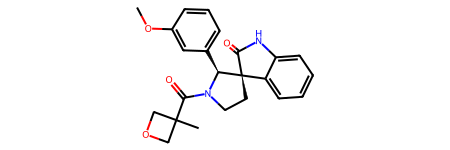

In [53]:
best_LSTM = best_molecules.sort_values(by='LSTM_label_2', ascending=False).iloc[0]
best_LSTM = best_LSTM[0]
mol = Chem.MolFromSmiles(best_LSTM)
mol

In [54]:
best_molecules.sort_values(by='roberta label_2', ascending=False)

,0,1,2,3,4,5,roberta_label_0,roberta_label_1,roberta label_2,LSTM_label_0,LSTM_label_1,LSTM_label_2,roberta_label,LSTM_label
729523,C12NN=C(C3=CC=C(C=C3)C)C=1C(N(C1C=CC(=CC=1)C(O...,MCULE-3791875033,427.435,4.97222,2.0,3.0,0.006711,0.125144,0.868145,0.999999,0.978910,0.759004,2,2.0
3446581,C12(O)CCC(C3COC(=O)C=3)[C@@]1(C)C(C[C@]1([H])[...,MCULE-8389290382,474.594,3.71670,1.0,7.0,0.015581,0.121823,0.862596,1.000000,0.992922,0.522239,2,2.0
1275541,C12C(=O)N(CC3ON=C(C4C=CC=CC=4)N=3)C=NC=1C1C(=C...,MCULE-8126048799,494.486,4.22730,1.0,8.0,0.017598,0.123806,0.858597,1.000000,0.981905,0.695895,2,2.0
765281,C12C(=O)N(CC(=O)NCC3=CC=CC=C3OC)N=CC=1C1C(=CC=...,MCULE-6281711945,470.504,3.86360,1.0,6.0,0.029090,0.128991,0.841918,0.999999,0.994805,0.959358,2,2.0
3646736,[C@@]12(C3=CC=CC=C3NC1=O)N1CCC[C@@]1(C[C@@H]2C...,MCULE-6639428738,421.457,1.32450,3.0,5.0,0.025811,0.133765,0.840424,1.000000,0.997131,0.954712,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419650,C1(C(=O)C2C=CC3=C(CC(O3)C)C=2)C(C2=CC=CC=C2OC)...,MCULE-5579773338,456.498,4.19210,1.0,6.0,0.328750,0.307852,0.363398,0.999999,0.950283,0.697417,2,2.0
1929176,C12CCN(CCN1C(=O)C=C(OCC1=CC=CS1)C=2C(OC)=O)C(=...,MCULE-7490498048,462.527,2.71180,0.0,7.0,0.351489,0.288759,0.359752,1.000000,0.983786,0.579140,2,2.0
3620776,N12C(=O)C=CC=C1[C@@]1(C[C@@]([H])(CN(C1)C(=O)C...,MCULE-2599314462,398.478,3.92980,1.0,4.0,0.301260,0.345296,0.353444,1.000000,0.994869,0.853041,2,2.0
1868725,C1[C@@H](O)[C@@](C)(CO)[C@@]2([C@](C)([C@@]([H...,MCULE-5521128905,350.455,1.96260,3.0,5.0,0.322960,0.325258,0.351782,1.000000,0.998016,0.730594,2,2.0


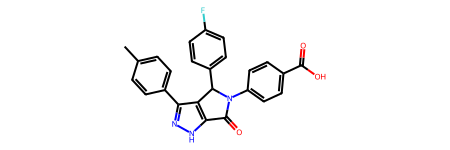

In [55]:
best_roberta = best_molecules.sort_values(by='roberta label_2', ascending=False).iloc[0]
best_roberta = best_roberta[0]
mol = Chem.MolFromSmiles(best_roberta)
mol

In [ ]:
https://en.wikipedia.org/wiki/Lanabecestat#/media/File:Lanabecestat.svg


In [56]:
beta = pd.read_csv('beta_activity_class.csv')

In [57]:
beta

,Ligand SMILES,activity_class
0,CCSc1cnc(cn1)C(=O)Nc1cccc(c1)[C@]1(C)CCSC(N)=N1,moderately_active
1,C[C@]1(CCSC(N)=N1)c1cc(NC(=O)CCc2ccc(O)c(O)c2)...,moderately_active
2,COc1nc(nc(C)c1F)N1C[C@H]2C(=O)N(C)C(=N)N[C@]2(...,moderately_active
3,COc1nc(nc(C)c1F)N1C[C@H]2C(=O)N(C)C(=N)N[C@]2(...,moderately_active
4,COc1nc(nc(C)c1F)N1C[C@H]2C(=O)N(C)C(=N)N[C@]2(...,moderately_active
...,...,...
15992,FC(F)(F)c1ccc(N\N=C\c2coc3cc4oc(cc4cc3c2=O)-c2...,inactive
15993,COc1ccc(cc1)-c1cc2cc3c(cc2o1)occ(\C=N\Nc1ccc(c...,inactive
15994,COc1ccc(CN(CCN(C)CCN)c2ccccn2)cc1,inactive
15995,Fc1cccc(c1)-c1cc2c(ccc3c2occ(\C=N\Nc2ccc(cc2)C...,inactive


In [58]:
#exclude the molecules from the df that are in the beta dataframe
df_nobeta = df[~df[0].isin(beta['Ligand SMILES'])]

In [59]:
df_nobeta

,0,1,2,3,4,5,roberta_label_0,roberta_label_1,roberta label_2,LSTM_label_0,LSTM_label_1,LSTM_label_2,roberta_label,LSTM_label
0,C1CCCC1,MCULE-8453099153,70.135,1.95050,0.0,0.0,0.165848,0.764494,0.069658,1.0,0.006782,0.001908,1,0.0
1,C1C=CC=CC=1,MCULE-4899719484,78.114,1.68660,0.0,0.0,0.927265,0.060617,0.012118,1.0,0.012577,0.001891,0,0.0
2,C1CCCCC1,MCULE-3136361765,84.162,2.34060,0.0,0.0,0.290897,0.636772,0.072330,1.0,0.007860,0.002047,1,0.0
3,CC1C=CC=CC=1,MCULE-4817136027,92.141,1.99502,0.0,0.0,0.424815,0.483570,0.091614,1.0,0.008427,0.001820,1,0.0
4,CC1C(C)=CC=CC=1,MCULE-2208963094,106.168,2.30344,0.0,0.0,0.600777,0.381564,0.017658,1.0,0.006512,0.001790,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3734076,O=S(=O)(NC1(CC1)C)C1C=C(N2C[C@H](C)N[C@@H](C)C...,MCULE-2493351182,497.597,2.83200,2.0,9.0,0.831880,0.085709,0.082410,1.0,0.702264,0.009186,0,1.0
3734077,O=C(C1C(O)=CC(O)=CC=1O)N,MCULE-6427173920,169.136,-0.09770,4.0,4.0,0.991116,0.007301,0.001583,1.0,0.006774,0.001384,0,0.0
3734078,CCCC/N=C/C1C=CC=CN=1,MCULE-3679160990,162.236,2.30060,0.0,2.0,0.966483,0.029608,0.003909,1.0,0.011911,0.001950,0,0.0
3734079,C(N1CCC[C@@H]1C(=O)O)([C@@H]1CCCN1C(=O)OCC1C=C...,MCULE-7004283865,346.383,1.86320,1.0,4.0,0.908618,0.087909,0.003473,1.0,0.003286,0.001017,0,0.0
